---

# Data Mining:<br>Statistical Modeling and Learning from Data

## Dr. Ciro Cattuto<br>Dr. Laetitia Gauvin<br>Dr. André Panisson

### Exercises - Learning Curves, Bias-Variance

---

In [61]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'degrees']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Illustration of the Bias-Variance Tradeoff with Scikit-Learn

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit

In [62]:
def test_func(x, err):
    y = np.sin(x*np.pi*2)  #funzione seno con un errore gaussiano
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

In [63]:
def make_data(n=40, error=0.1, random_seed=1):
    # randomly sample the data
    np.random.seed(random_seed)  #setto un seme, che verrà usato dal 
                                 #generatore di numeri casuali
    X = np.random.random(n)[:, np.newaxis]  #genero 40 numeri random che 
                                            #seguono una distribuzione 
                                            #random. Poi trasformo questo
                                            #vett. 1D in una matrice 2D
                                            #con 1 colonna
    y = test_func(X.ravel(), error) #creo la funzione sin+rumore
    
    return X, y

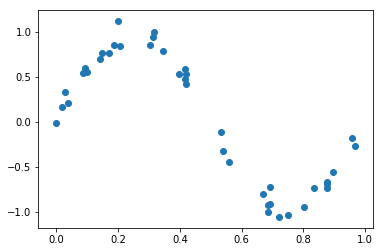

In [64]:
X, y = make_data(40)
plt.scatter(X, y)

Now say we want to perform a regression on this data.  Let's use the built-in linear regression function to compute a fit:

mean squared error: 0.1985235000298568


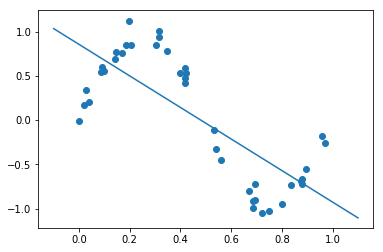

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X_test = np.linspace(-0.1, 1.1, 500)[:, None] #[:, None] è uguale
                                              #a [:, np.newaxis]. Trasforma 
                                              #vett. riga 1D in una matrice 
                                              #con una sola colonna (500x1)
            #ci serve una matrice 2D perchè la funzione predict prevede 
            #quella come argomento

model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
print("mean squared error:", metrics.mean_squared_error(model.predict(X), y))
#questo errore sarebbe Ein, è l'errore sul nostro training set

We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model is **biased**, or that it **under-fits** the data.

Let's try to improve this by creating a more complicated model.  We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs.  Let's make this easier by creating a quick PolynomialRegression estimator:

In [66]:
class PolynomialRegression(LinearRegression):
    """Simple Polynomial Regression to 1D data"""
    def __init__(self, degree=1, **kwargs): #costruttore: di default 
                        #la regressione è a 1 grado. C'è un numero variabili
                        #di parametri
        self.degree = degree
        LinearRegression.__init__(self, **kwargs) #il costruttore della 
            #regres. polinomiale usa il costruttore della regres. lineare
        
    def fit(self, X, y):
        if X.shape[1] != 1: #se ho più di una dimensione non va bene
                            #quindi se ho più di una colonna non va bene
            raise ValueError("Only 1D data valid here")
        Xp = X ** (1 + np.arange(self.degree)) #termini di grado successivo
                                               #del fit. Avrò p termini (per
                                               #un polinomio di grado p)
                #sto partendo da X, un vettore riga lungo N (per esempio),
                #applico la trasformazione non lineare e ottengo Xp: una
                #matrice pxN
        return LinearRegression.fit(self, Xp, y) #applico la regres. lineare 
                                                 #alla matrice Xp
                # --> restituisco il modello trovato
        
    def predict(self, X):
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.predict(self, Xp) #applico il modello trovato
                #con fit() ai punti di Xp. --> restituisce le predizioni

In [69]:
#PROVE
"""
A = array([[1],[2],[3]])
print(A)
print(A.shape[1])
Xp = A**(1 + np.arange(5))
print (Xp)
"""

'\nA = array([[1],[2],[3]])\nprint(A)\nprint(A.shape[1])\nXp = A**(1 + np.arange(5))\nprint (Xp)\n'

Now we'll use this to fit a quadratic curve to the data.

mean squared error: 0.1897122312420034


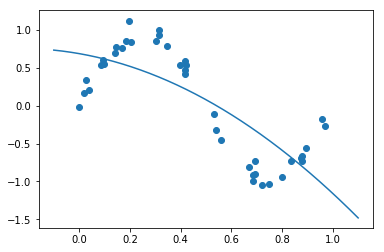

In [71]:
model = PolynomialRegression(degree=2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
print("mean squared error:", metrics.mean_squared_error(model.predict(X), y))
#con questo modello un po' più complesso l'errore migliora

This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

mean squared error: 0.0028293850053982927


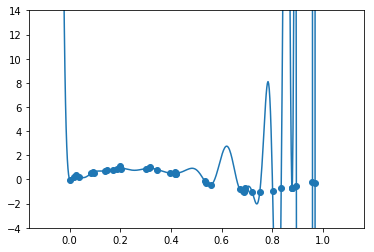

In [27]:
model = PolynomialRegression(degree=60) #Polinomio di grado 60! molto complesso!
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.ylim(-4, 14)
print("mean squared error:", metrics.mean_squared_error(model.predict(X), y))
#modello super complicato -> errore piccolo!
#però avrò una differenza molto alta tra Ein e Eout (non riesco a generalizzare
#bene) --> ho bisogno di un n molto più grande affinchè Ein approssimi
#bene Eout

When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

## Detecting over-fitting
Clearly, computing the error on the training data is not enough (we saw this previously).  But computing the *validation error* can help us determine what's going on: in particular, comparing the training error and the validation error can give you an indication of how well your data is being fit.

Let's do this:

Text(0,0.5,'MSE')

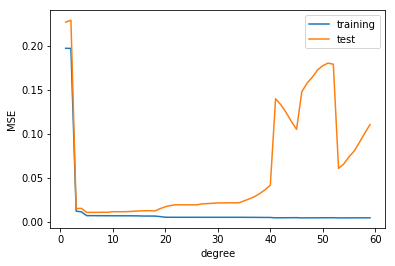

In [72]:
from sklearn.model_selection import train_test_split

degrees = np.arange(1, 60)

X, y = make_data(100) #dataset di 100 punti. X è una matrice 100x1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#X_train è una matrice 70x1, X_test è 30x1

training_error = [] #Ein vettore degli Ein ottenuti con i diveri modelli
                    #che proveremo
test_error = [] #Eout
mse = metrics.mean_squared_error #def la funzione che voglio usare per
                                 #calcolare l'errore

for d in degrees:
    model = PolynomialRegression(d).fit(X_train, y_train) #applico il primo modello
    training_error.append(mse(model.predict(X_train), y_train))    #mse = mean squared error #calcolo il primo Ein
    test_error.append(mse(model.predict(X_test), y_test)) #calcolo il primo Eout       --> ripeto per tutti i d cicli
    
# note that the test error can also be computed via cross-validation
plt.plot(degrees, training_error, label='training')
plt.plot(degrees, test_error, label='test')
plt.legend()
plt.xlabel('degree')
plt.ylabel('MSE')

#plotto Ein e Eout al variare della complessità del mio modello
#qua il trainingset è fisso: N = 70 punti (il 70% del dataset, che sono 100 punti)
#Crescendo in complessità del modello Ein (training) diventa sempre più preciso
#(verso 40-50 ha delle piccole fluttuazioni che non dovrebbe avere teoricamente)
#la Eout invece (test), ad un certo punto sale di colpo.
#In questo caso una funzione di grado 3-4 potrebbe andare bene

In [34]:
np.argmin(test_error) #posizione del valore minore nella lista
# polinomio di quinto grado è quello ottimale per fittare questi dati

5

(-1.5, 1.5)

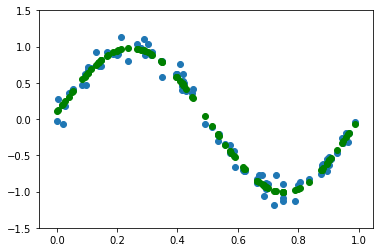

In [39]:
d = degrees[np.argmin(test_error)] #facciamo un fit con pol di grado 5

model = PolynomialRegression(d).fit(X_train, y_train)
y_pred = model.predict(X)

plt.scatter(X.ravel(), y)
plt.scatter(X.ravel(), y_pred, c = 'g')
plt.ylim(-1.5, 1.5)

# Illustration of dependency of $E_{\mathbf{in}}$ and $E_{\mathbf{out}}$ in relation to $N$

For this section, we will see how a classification model behaves when we increase the number of samples. We will work on a 2D classification problem, and the results generalize to higher dimensional datasets.

We will generate 1000 samples from a bivariate Gaussian distribution $\mathcal{ N } ((2, 0)^T , I)$ and will label this class **RED**. Similarly, 1000 more are drawn from $ \mathcal{N} ((0, 2)^T , I)$ and are labeled **GREEN**.

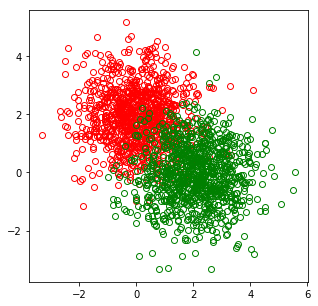

In [75]:
np.random.seed(2)
nr_samples = 2000 #dataset di 2000 punti: sono due gaussiane 2D centrate in 
                  # (0,2) e (2,0).

# Generate samples from two bivariate Gaussian distributions
samples_red   = np.random.multivariate_normal(mean=(0,2), cov=np.identity(2), size= nr_samples//2)
samples_green = np.random.multivariate_normal(mean=(2,0), cov=np.identity(2), size=nr_samples//2)

# Join the red and green datasets as X and the class definitions as y
X = np.concatenate([samples_red, samples_green])
y = np.zeros(nr_samples, dtype=int)
y[nr_samples//2:] = 1

# plot the red and green class points
figure(num=None, figsize=(5, 5))
plot(samples_red[:,0], samples_red[:,1], 'o', mec='r', mfc='none')
plot(samples_green[:,0], samples_green[:,1], 'o', mec='g', mfc='none')

A 2D classification can be accomplished within Scikit-Learn with the `sklearn.linear_model` module.
We will divide the dataset in two parts: a train dataset and a test dataset. This can be accomplished within Scikit-Learn with the function `train_test_split` from the package `cross_validation`.

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Let's build a Logistic Regression model and evaluate both $E_{\mathbf{in}}$ and $E_{\mathbf{out}}$ for the instance trained with the train set, where the error is defined as the mean absolute error:

In [83]:
from sklearn import linear_model, metrics

def evaluate(X_train, y_train, X_test, y_test):
    #funzione che mi calcola sia il modello da usare (con la regres. lineare)
    #sia l'errore del modello (sia Ein che Eout).
    model = linear_model.LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)

    ein = metrics.mean_absolute_error(model.predict(X_train), y_train) #errore assoluto medio
    eout = metrics.mean_absolute_error(model.predict(X_test), y_test)
    
    return ein, eout

print(evaluate(X_train, y_train, X_test, y_test))

#sto facendo un errore di 7.5% sul training set e un errore dell'8% sul test set
# Il valore migliore è 0.0 quindi direi di interpretarlo così 


(0.076, 0.081)


Then let's create a function that runs the evaluation for a number of realizations, but in every realization selects randomly from the training set a fixed number of samples (`n_samples`) and evaluates the Logistic Regression:

In [84]:
def evaluate_many(X_train, y_train, X_test, y_test, n_samples=100, n_realizations=100):
    
    n_max = X_train.shape[0]
    ein_n = []
    eout_n = []
    
    #in questo caso non ho dataset fisso, faccio diverse realizzazioni di 
    #diversi dataset. Ogni volta genero un dataset di 100 punti e ogni volta
    #vado a calcolare Ein e Eout
    
    for i in range(n_realizations): 
    
        f = np.random.choice(n_max, n_samples, replace=False)
        X_train_filtered = X_train[f]
        y_train_filtered = y_train[f]
        
        ein, eout = evaluate(X_train_filtered, y_train_filtered, X_test, y_test)
        
        ein_n.append(ein)
        eout_n.append(eout)
    
    return np.mean(ein_n), np.mean(eout_n)

print(evaluate_many(X_train, y_train, X_test, y_test, n_samples=50))

#l'errore Eout è un po' più grande di prima: sto facendo 100 regresioni
#lineare su training set ridotti, di soli 50 punti --> i modelli trovati 
#su questi pochi punti hanno una capacità di generalizzazione peggiore.
# (X_train era costituito da 1000 punti, ora uso training set di 50 punti)

(0.05840000000000001, 0.08962999999999997)


Finally, we will evaluate the Logistic Regression model for different datasets, fixing the number of samples:

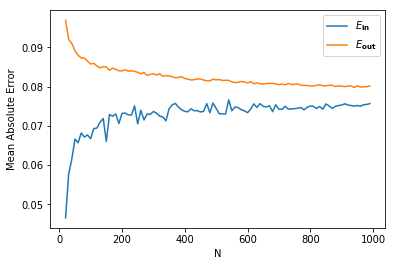

In [85]:
random.seed(2)

n_list = arange(20,1000,10) #da 20 a 1000 a passi di 10: per ognuno di questi n
                            #vado a valutare Ein e Eout

n_max = X_train.shape[0]

ein_list = []
eout_list = []

for n in n_list:
    
    ein_n, eout_n = evaluate_many(X_train, y_train,
                                  X_test, y_test, n_samples=n)
    
    ein_list.append(ein_n)
    eout_list.append(eout_n)
    
plot(n_list, ein_list, label="$E_{\mathbf{in}}$")
plot(n_list, eout_list, label="$E_{\mathbf{out}}$")
xlabel('N')
ylabel('Mean Absolute Error')
legend();

# Exercise: Bias and Variance on a sine function

For this exercise, we will produce data from a target function $f(x) = \sin(\pi x)$.

For $N$ times, we will choose two points from the interval $[-1,1]$ and evaluate $f(x)$ for these points.
Then, we will create two classes of functions: $h_0$ and $h_1$. The functions in $h_0$ are linear regressions of the type $y = b$, while $h_1$ are linear regressions of the type $y = ax + b$.

In [86]:
f = lambda x: sin(pi*x)
N = 100 #numero di funzioni che andiamo a mettere in questi due set di ipotesi
h0 = []
h1 = []

for i in  range(N):
    d = random.uniform(-1, 1, 2) #ad ogni passo scegliamo due punti dell'asse x
    y = f(d) #calcoliamo la funzione nei due punti 
    
    g0 = poly1d(polyfit(d, y, 0)) #fittiamo i punti di coordinate (d,y) con
                                    #polinomio di grado 0
    h0.append(g0)
    
    g1 = poly1d(polyfit(d, y, 1)) #fit con polinomio di grado 1
    h1.append(g1)

In [87]:
? polyfit()

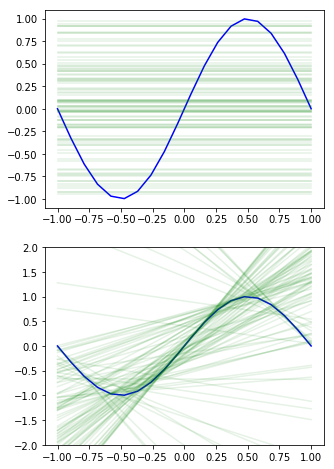

In [88]:
fig = plt.figure(figsize=(5,8))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

x = linspace(-1, 1, 20)

ax1.plot(x, f(x), 'b')
ylim(-2,2)
ax2.plot(x, f(x), 'b')
ylim(-2,2)

for i in  range(N):
    ax1.plot(x, h0[i](x), 'g', alpha=0.1)
    ax2.plot(x, h1[i](x), 'g', alpha=0.1)

In [45]:
h1 #lista di 100 funzioni lineare --> due parametri-- rette 

[poly1d([-0.27949383, -0.4271812 ]),
 poly1d([3.07104637e+00, 1.96783743e-03]),
 poly1d([ 2.19677267, -0.1298596 ]),
 poly1d([1.97876003, 0.20918354]),
 poly1d([ 0.65023641, -0.69118112]),
 poly1d([2.7591565 , 0.02126852]),
 poly1d([1.09970644, 0.0553465 ]),
 poly1d([1.57415651, 0.07713087]),
 poly1d([ 1.15401601, -0.02290154]),
 poly1d([0.84841538, 0.23347001]),
 poly1d([0.49067636, 0.02780792]),
 poly1d([ 0.20143558, -0.40746691]),
 poly1d([1.3711641 , 0.30581186]),
 poly1d([-1.53755633, -1.83120703]),
 poly1d([ 0.66780332, -0.60908506]),
 poly1d([ 1.41586572, -0.10980098]),
 poly1d([ 2.79119073, -0.01166422]),
 poly1d([2.8951279e+00, 2.5753971e-03]),
 poly1d([1.1254573 , 0.30169411]),
 poly1d([1.6756174, 0.2797384]),
 poly1d([2.37698863e-01, 4.85599005e-05]),
 poly1d([ 1.34931486, -0.41142583]),
 poly1d([3.04142691e+00, 1.04750938e-03]),
 poly1d([ 2.0204664 , -0.13144864]),
 poly1d([0.07739665, 0.21633508]),
 poly1d([0.83037676, 0.20079109]),
 poly1d([ 1.5999433 , -0.31681742]),
 po

In [46]:
h0 #lista di 100 funzioni con 1 parametro -- costanti 

[poly1d([-0.27679148]),
 poly1d([-0.04414432]),
 poly1d([-0.67750926]),
 poly1d([-0.13923732]),
 poly1d([-0.97307034]),
 poly1d([0.43590332]),
 poly1d([-0.33157634]),
 poly1d([0.02955201]),
 poly1d([0.37894083]),
 poly1d([0.17086286]),
 poly1d([-0.18292158]),
 poly1d([-0.50321866]),
 poly1d([-0.07275931]),
 poly1d([-0.8055919]),
 poly1d([-0.89615201]),
 poly1d([-0.57770112]),
 poly1d([0.33298241]),
 poly1d([-0.30972387]),
 poly1d([0.72221181]),
 poly1d([0.05026418]),
 poly1d([0.11047381]),
 poly1d([-0.09955367]),
 poly1d([-0.01510219]),
 poly1d([0.29952987]),
 poly1d([0.25420886]),
 poly1d([-0.10951815]),
 poly1d([0.03067891]),
 poly1d([-0.36276298]),
 poly1d([-0.70465977]),
 poly1d([0.1112089]),
 poly1d([0.77376859]),
 poly1d([0.06081694]),
 poly1d([-0.40652186]),
 poly1d([-0.53347204]),
 poly1d([-0.12727173]),
 poly1d([-0.43499854]),
 poly1d([-0.8252422]),
 poly1d([0.93333321]),
 poly1d([-0.38492682]),
 poly1d([-0.01831012]),
 poly1d([0.16830742]),
 poly1d([0.10116215]),
 poly1d([-0.

In the next, you will calculate the **bias** and **variance** for the two classes of functions: $h_0$ and $h_1$.

For the solution, proceed with the following steps:

1. Create a list `x` of 100 values between -1 and 1. These values will be used to evaluate the two classes of functions at different points.
2. Create a list of values $g_0$ that represents the average of the functions $h_0$ in each point of `x`:
    $${g_0}_k = \frac{1}{N}\sum_i^N{{h_0}_i(x_k)}$$
3. Create a list of values $g_1$ that represents the average of the functions $h_1$ in each point of `x`:
    $${g_1}_k = \frac{1}{N}\sum_i^N{{h_1}_i(x_k)}$$
4. Assign to $\mathbf{bias}_0$ the average of the squares of the differences between $g_0$ and $f$:
    $$\mathbf{bias}_0 = \frac{1}{N}\sum_i^N{\left({g_0}(x_i) - f(x_i)\right)^2}$$
5. Assign to $\mathbf{bias}_1$ the average of the squares of the differences between $g_1$ and $f$:
    $$\mathbf{bias}_1 = \frac{1}{N}\sum_i^N{\left({g_1}(x_i) - f(x_i)\right)^2}$$
6. Assign to a matrix $\mathbf{var}_0$ the the differences between the functions $h_0$ and $g_0$ in each point of `x`:
    $${\mathbf{var}_0}_{ij} = {\left({h_0}_i(x_j) - g_0(x_j)\right)^2}$$
7. Assign to a matrix $\mathbf{var}_1$ the differences between the functions $h_1$ and $g_1$ in each point of `x`:
    $${\mathbf{var}_1}_{ij} = {\left({h_1}_i(x_j) - g_1(x_j)\right)^2}$$

In [89]:
#dobbiamo applicare h0 ai nostri dati x
[h(x) for h in h0] #lista di tutte e 100 le funzioni h0 calcolate in x
#ho matrice con: ogni riga --> valori di una determinata h
#devo fare la media sui valori delle colonne
g0 = np.mean([h(x) for h in h0], axis=0)

In [90]:
g0

array([0.03289532, 0.03289532, 0.03289532, 0.03289532, 0.03289532,
       0.03289532, 0.03289532, 0.03289532, 0.03289532, 0.03289532,
       0.03289532, 0.03289532, 0.03289532, 0.03289532, 0.03289532,
       0.03289532, 0.03289532, 0.03289532, 0.03289532, 0.03289532])

In [91]:
#calcolo la g1:
g1 = np.mean([h(x) for h in h1], axis = 0)

In [92]:
#calcoliamo i bias:
bias0 = np.mean((g0 - f(x))**2)
bias1 = np.mean((g1 - f(x))**2)

In [93]:
#calcoliamo le varianze:
var0 = 0    #per tutte le h0 devo fare la media degli scarti al quadrato di 
            #(h0,1 - g0)
var0 = np.mean([(h(x) - g0)**2 for h in h0])
var1 = np.mean([(h(x) - g1)**2 for h in h1])

In [94]:
bias0

0.4760821022795776

In [95]:
bias1

0.23198309682268806

In [96]:
var0

0.2466137900767068

In [97]:
var1

1.827057339997677

In [98]:
#controlliamo se il set di ipotesi è buono:
bias0 + var0

0.7226958923562844

In [99]:
bias1 + var1

2.059040436820365

In [100]:
#nel nostro caso, con training set di 2 punti, è meglio il set h0.

# ESERCIZIO:
#quale set di ipotesi scegliersti con un set di ipotesi di 3 punti ???

(0.16804658950889365, 0.4754535273458124) (0.5359286967380271, 0.24395979837450343)
0.6435001168547061 0.7798884951125306


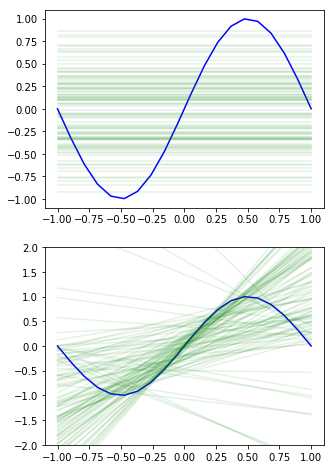

In [101]:
# ESERCIZIO:
#quale set di ipotesi scegliersti con un set di ipotesi di 3 punti ???

#prendo 100 triplette di punti. Per questi calcolo il valore di f.
#per ognuna di queste triplette calcolo i parametri dei fit g0 e g1
f = lambda x: sin(pi*x)
N = 100 #numero di funzioni che andiamo a mettere in questi due set di ipotesi
h0 = []
h1 = []

for i in  range(N):
    d = random.uniform(-1, 1, 3) #ad ogni passo scegliamo tre punti dell'asse x
    y = f(d) #calcoliamo la funzione nei due punti 
    g0 = poly1d(polyfit(d, y, 0)) #fittiamo i punti di coordinate (d,y) con
                                    #polinomio di grado 0
    h0.append(g0)
    g1 = poly1d(polyfit(d, y, 1)) #fit con polinomio di grado 1
    h1.append(g1)
    
#disegno i fit per le 100 triplette    
fig = plt.figure(figsize=(5,8))

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

x = linspace(-1, 1, 20)

ax1.plot(x, f(x), 'b')
ylim(-2,2)
ax2.plot(x, f(x), 'b')
ylim(-2,2)

for i in  range(N):
    ax1.plot(x, h0[i](x), 'g', alpha=0.1)
    ax2.plot(x, h1[i](x), 'g', alpha=0.1)
    #ax1.scatter(d,y)
    #ax2.scatter(d,y)
    
#calcolo go e g1, bias0 e bias1, var0 e var1, err0 e err1    
[h(x) for h in h0] 
g0 = np.mean([h(x) for h in h0], axis=0)
g1 = np.mean([h(x) for h in h1], axis=0)

bias0 = np.mean((g0 - f(x))**2)
bias1 = np.mean((g1 - f(x))**2)

var0 = np.mean([(h(x) - g0)**2 for h in h0])
var1 = np.mean([(h(x) - g1)**2 for h in h0])

err0 = bias0 + var0
err1 = bias1 + var1

print((var0, bias0), (var1, bias1))
print(err0, err1)